In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
#wqad

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

# Heart Disease

# **Research Question:** How do a person’s health factors influence the likelihood of that person having a heart disease? 

# Introduction

Heart disease is a broad term for many heart conditions. A person can go undiagnosed for most of their life until they experience a major symptom such as a heart attack or even heart failure. Many personal health factors can affect their risk of having a heart disease. This includes, cholesterol, age, and sex.  
For this analysis, we will be using the UCI Machine Learning Repository's Heart Disease dataset. This dataset includes 14 variables, including age, sex, chest pain type, resting blood pressure, cholesterol level, fasting blood sugar, resting ekg results. When analyzing this data, maximum heart rate achieved, exercise induced angina, it is intended to find what health factors can affect a person’s chance of having heart disease. 


# Methods and Results

To begin data analysis, the data is downloaded from the heart disease website as a csv document.

In [2]:
heart_disease <- read_csv("heart_disease.data", col_names=FALSE)
heart_disease

Parsed with column specification:
cols(
  X1 = col_double(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_double(),
  X5 = col_double(),
  X6 = col_double(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_double(),
  X10 = col_double(),
  X11 = col_double(),
  X12 = col_character(),
  X13 = col_character(),
  X14 = col_double()
)



X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


Table1.1: heart disease untidy trable

As we can see from table 1.1, the table doesn't have labels. Rename function is used to relable the dataset which makes the table more clear to the audience. Afterward, the dataset was split into training and testing datasets, with training dataset containing 75% of the original data, and testing dataset containing the rest 25%. Since our response variable is the 14th column "num", we set strata = num to make sure that both training and testing dataset contains similar ratio of "num" values.

In [3]:
#read and tidy the data
set.seed(100)
heart_disease <- read_csv("heart_disease.data", col_names=FALSE) %>%
    rename(age = X1,
            sex = X2,
          cp = X3,
          trestbps = X4,
          chol = X5,
          fbs = X6,
          restecg =X7,
          thalach = X8,
          exang =X9, 
          oldpeak =X10,
          slope =X11,
          ca = X12,
          thal = X13,
          num = X14) %>%
    mutate(num = as_factor(num))

#splitting data into training and testing dataset
heart_disease_split <- initial_split(heart_disease, prop = 0.75, strata = num)
disease_train <- training(heart_disease_split)
disease_test <- testing(heart_disease_split)

heart_disease

Parsed with column specification:
cols(
  X1 = col_double(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_double(),
  X5 = col_double(),
  X6 = col_double(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_double(),
  X10 = col_double(),
  X11 = col_double(),
  X12 = col_character(),
  X13 = col_character(),
  X14 = col_double()
)



age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


Table1.2: heart disease labelled trable<br>
Column 1 = age<br>
Column 2 = sex<br>
Column 3 = chest pain type<br>
Column 4 = resting blood pressure<br>
Column 5 = cholesterol level<br>
Column 6 = fasting blood sugar<br>
Column 7 = resting electrocardiographic results<br>
Column 8 = maximum heart rate achieved<br>
Column 9 = exercise induced angina<br>
Column 10 = ST depression induced by exercise relative to rest<br>
Column 11 = the slope of the peak exercise ST segment<br>
Column 12 = number of major vessels (0-3) colored by fluoroscopy<br>
Column 13 = thal<br>
Column 14 = diagnosis of heart disease (response variable). When num < 1, there's no risk of heart disease. When num > 1, there is diagnosed to be heart disease

Next, we simplified our response variable "num" from 0 - 4 to 0 - 2. We used ifelse() function to group num == 1 and 2 to the value 1, and grouped num == 3 and 4 to the value 2. Num value is also switched into pred, which stands for predictions. We are able to simply the response variable because when num equals to 1 and 2, it is considered to be low risk heart disease. When num equals to 3 and 4, it is considered to be moderate and high risk heart disease. Since pred is now our response variable, we have to mutate this vector into fct using the as_factor () function.

Looking at columns 12 and 13 closely, these vectors are considered as characters rather than doubles/integers. In order for our classifier to work they have to be changed into dbl using the as.numeric function.

In [4]:
#grouping the num column for visualization clarity
disease_num_train <- mutate(disease_train, pred = ifelse(num == 1 | num == 2, 1, ifelse(num == 3 | num == 4, 2, 0))) %>%
               select(-num) %>%
                filter(ca != "?") %>%
                filter(thal != "?") %>%
                     mutate(pred = as_factor(pred)) %>%
                     mutate(ca = as.numeric(ca))%>%
                     mutate(thal = as.numeric(thal))

disease_num_test <- mutate(disease_test, pred = ifelse(num == 1 | num == 2, 1, ifelse(num == 3 | num == 4, 2, 0))) %>%
               select(-num) %>%
                filter(ca != "?") %>%
                filter(thal != "?") %>%
                     mutate(pred = as_factor(pred)) %>%
                     mutate(ca = as.numeric(ca))%>%
                     mutate(thal = as.numeric(thal))

disease_num_train

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,pred
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
67,1,4,160,286,0,2,108,1,1.5,2,3,3,1
67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
45,1,1,110,264,0,0,132,0,1.2,2,0,7,1
57,1,4,130,131,0,0,115,1,1.2,2,1,7,2
57,0,2,130,236,0,2,174,0,0.0,2,1,3,1


Table 2.0: Training dataset with pred being the response variable <br>

As we have tidied the data already, to get a basic understanding between the relationships between predictors and the response variable pred, we assumed cholesterol level and age of the patient to be strongly correlated to heart disease diagnoses. Hence, we plotted a scatterplot diagram with age of patient (column 1) on the x axis and cholesterol level (column 5) on the y axis. We also colored the scatterplots based on their "pred" value. 

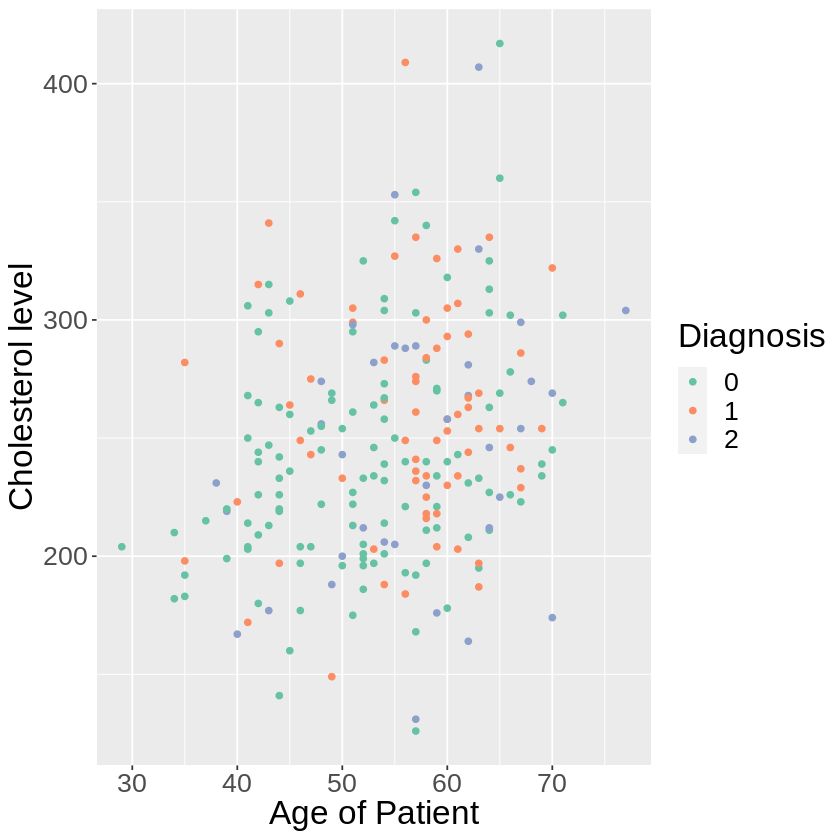

In [5]:
#creating the scattered plot
heart_disease_plot<-ggplot(disease_num_train, aes(x = age, y = chol, color = as_factor(pred))) +
geom_point() +
labs(x = "Age of Patient",
y = "Cholesterol level",
color = "Diagnosis") +
theme(text = element_text(size = 20)) +
scale_color_brewer(palette = "Set2")



heart_disease_plot

Graph 1.0 : The impact of age and cholesterol level of patients on heart disease diagnosis

Looking at the graph above, there're no distinct relationships between cholesterol level, age of patient, and pred. This is troublesome since building a classifier with these variables will not be able to create an accurate classifier. Moreover, since we have 13 predictors in total, it is very time consuming to find the best selection of predictors. Therefor, we'll be doing forward selection to find the combination of predictors that produces the most accurate classifier.

In [6]:
set.seed(100022)
#creating a new tibble for foward loops analysis
disease_subset <- disease_num_train %>% 
  select(age, 
         sex, 
         cp, 
         trestbps, 
         chol, 
         fbs, 
         restecg,
         thalach,
         exang,
         oldpeak,
         slope,
         ca,
         thal,
         pred)

names <- colnames(disease_subset %>% select(-pred)) 


# create a model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) %>%
     set_engine("kknn") %>%
     set_mode("classification")

# create a 5-fold cross-validation object
disease_vfold <- vfold_cv(disease_subset, v = 5, strata = pred)


To prepare for forward selection, data frame disease_subset is created. This data set includes all 14 variables in disease_num_train dataset. This dataset is created so that all predictors are in an organized form and is easy for the for loop to pull predictors from. In order to make this dataset work for forward selection, response variable pred is removed and the data-frame is redefined as names for convince.

Next, we created model specification "knn_spec", setting the neighbors argument as tune(), set engine as "kknn", set mode as "classification" as a preparation for for loops. We also created disease_vfold for 5-fold cross validation to be used in the calculation of different combinations of predictors' accuracy.

In [7]:
# create an empty tibble to store the results
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

# store the total number of predictors
n_total <- length(names)

# stores selected predictors
selected <- c()

An empty tibble "accuracies" is created to store the results of for loops. For this tibble, the size for the results is integer, model_string (part of the recipe) will be printed as chr, and accuracy will be reported as dbl. 

n_total is the total number of predictors, and selected is an empty vector created for foward selection to store selected predictors.

In [8]:
# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("pred", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        disease_recipe <- recipe(as.formula(model_string), 
                                data = disease_subset) %>%
                          step_scale(all_predictors()) %>%
                          step_center(all_predictors())

        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() %>%
          add_recipe(disease_recipe) %>%
          add_model(knn_spec) %>%
          tune_grid(resamples = disease_vfold, grid = 10) %>%
          collect_metrics() %>%
          filter(.metric == "accuracy") %>%
          summarize(mx = max(mean))
        acc <- acc$mx %>% unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies %>% 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>
1,pred ~ cp,0.6449715
2,pred ~ cp+oldpeak,0.6941722
3,pred ~ cp+oldpeak+ca,0.6892227
⋮,⋮,⋮
11,pred ~ cp+oldpeak+ca+thal+exang+chol+slope+trestbps+fbs+thalach+age,0.7289196
12,pred ~ cp+oldpeak+ca+thal+exang+chol+slope+trestbps+fbs+thalach+age+sex,0.7379183
13,pred ~ cp+oldpeak+ca+thal+exang+chol+slope+trestbps+fbs+thalach+age+sex+restecg,0.7151954


table3.0: accuracies of predictor combinations from size 1 to 13

Unfortunately the for loops cannot be broken down into small sections, but the overall logic is simple. The forward selection conducted consists of two for loops. For the first for loop, the range is from 1 to n_total. In the first loop, we firstly create lists accs and models. If i is in the range for the first loop, then it will enter the second loop. For the second loop, the range is from 1 to length of names (13). The goal of the first two steps of the second loop is to select predictors and make the response variable ~ predictors combination. This combination is defined as model_string, which will then be used to produce the recipe disease_recipe. As forward selection progresses, model_string will depend on newly entered variables, which eventually changes information entered in the recipe. After the recipe is made, a workflow is assembled. Just like all the workflow studied in class, this one is no different. add_recipe and add_model adds the recipe and specification made earlier. Tune grid, collect metrics, filter, and summaries(mx = max(mean) selects the best k, filters the accuracy, and collects the highest accuracy for the best k. This accuracy value collected is unlisted and stored in acc. The second loop ends with acc and model string collected as j. Finally, we create a variable called jstar, which is essentially the highest accuracy for each size of combinations of predictors. Values of Jstar, which is its size, model_string, and respective accuracy is stored in the tibble "accuracies". In the last stage of the first loop, we put all of the calculated variables back to names and vector "selected", and remove jstar from names (for preparation for the next loop). The for loops will keep on running until i > n_total.

In [10]:
max1 <- arrange(accuracies, accuracy)
max1

size,model_string,accuracy
<int>,<chr>,<dbl>
1,pred ~ cp,0.6449715
3,pred ~ cp+oldpeak+ca,0.6892227
5,pred ~ cp+oldpeak+ca+thal+exang,0.6937593
⋮,⋮,⋮
11,pred ~ cp+oldpeak+ca+thal+exang+chol+slope+trestbps+fbs+thalach+age,0.7289196
8,pred ~ cp+oldpeak+ca+thal+exang+chol+slope+trestbps,0.7338603
12,pred ~ cp+oldpeak+ca+thal+exang+chol+slope+trestbps+fbs+thalach+age+sex,0.7379183


table 3.1: arranged accuracies of predictors

In [9]:
set.seed(100022)
#find k
disease_best_recipe <- recipe(pred~cp+oldpeak+thal+slope+ca+exang+chol+trestbps+fbs+thalach, 
                                data = disease_num_train) %>%
                          step_scale(all_predictors()) %>%
                          step_center(all_predictors())

disease_vfold_1 <- vfold_cv(disease_num_train, v = 5, strata = pred) 

k_vals <- tibble(neighbors = seq(from = 1, to = 40))

knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) %>%
     set_engine("kknn") %>%
     set_mode("classification")

knn_fit <- workflow() %>%
  add_recipe(disease_best_recipe) %>%
  add_model(knn_spec) %>%
  tune_grid(resamples = disease_vfold_1, grid = k_vals) %>%
  collect_metrics() %>%
  filter(.metric == "accuracy") %>%
  select(neighbors, mean) %>%
  arrange(mean)

knn_fit

neighbors,mean
<int>,<dbl>
1,0.5958674
2,0.5958674
3,0.6629337
⋮,⋮
10,0.7109486
5,0.7157795
9,0.7199341


table 4.1: neighbours and their mean accuracy

Now by completing the forward selection we have the combination of predictors that produces the classifier with the highest accuracy.  Using this information, disease_best_recipe is created. To select the best k value, a new 5-fold cross validation is created using disease_num_train. Afterward, the new recipe and knn_spec is added to a workflow  that uses tune_grid to calculate the accuracies of the classifier with different k values. After using collect_metrics, filter, select, and arrange functions that collects the accuracies of the classifier, we get the best k value.

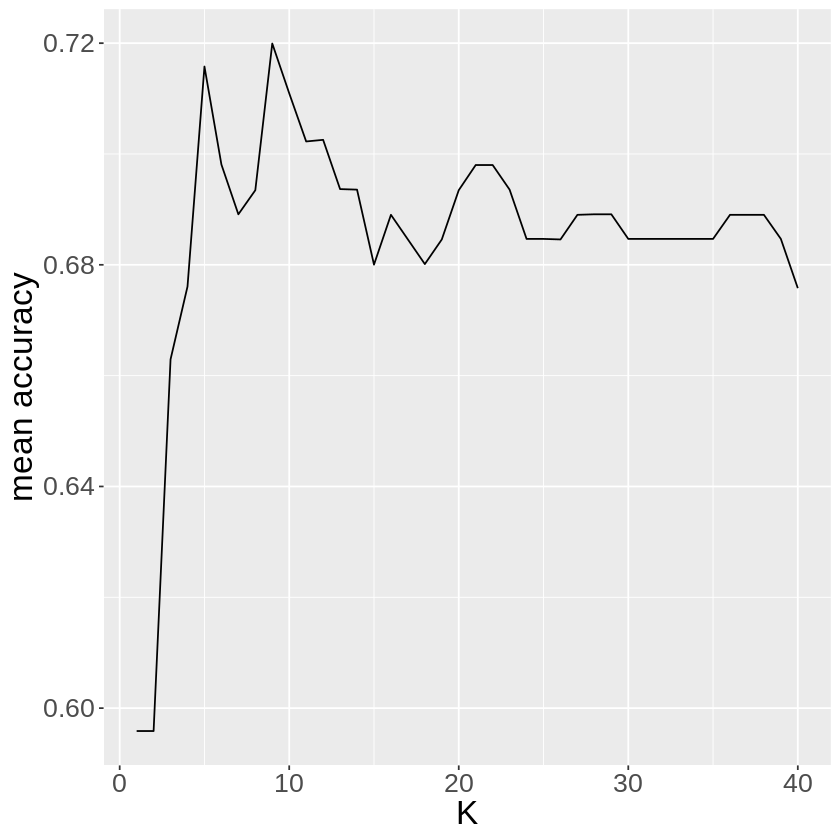

In [13]:
k_line <- ggplot(knn_fit, aes(x = neighbors, y = mean)) +
  geom_line() +
  xlab("K") +
  ylab("mean accuracy") +
  theme(text = element_text(size = 20))
k_line

graph4.0: visulization for the k values and mean accuracies

In [13]:
#final calculation

disease_best_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = 9) %>%
     set_engine("kknn") %>%
     set_mode("classification")


knn_fit <- workflow() %>%
  add_recipe(disease_best_recipe) %>%
  add_model(disease_best_spec) %>%
  fit(data = disease_num_train)

disease_predict <- predict(knn_fit, disease_num_test) %>%
    bind_cols(disease_num_test) %>%
    metrics(truth = pred, estimate = .pred_class) %>%
    filter(.metric == "accuracy") %>%
    select(.estimate) %>%
    pull()
disease_predict

[1] 0.625

Calculate the accuracy of the classifier by first finalizing the recipe (k=9), add this recipe to a workflow and train the classifier with disease_num_train using the fit function. Finally, use predict function to predict the "pred" for disease_num_test dataset. Use bind_cols, metrics, filter, select, and pull function to calculate the accuracy of the classifier and filter out unnecessary information.

# discussion

Observing the analysis above, loading and wrangling the data had produced a dataset with response variable “num (diagnosis of heart disease)” and 13 predictors, respectively being age, sex, chest pain type, resting blood pressure, cholesterol level, fasting blood sugar, resting electrocardiographic results, maximum heart rate achieved, exercise induced angina,  ST depression induced by exercise relative to rest, the slope of the peak exercise ST segment, number of major vessels (0-3) colored by fluoroscopy,  and thal. The attempt to visualize the data by creating a scatterplot with “age” on the x-axis, “chol” on the y-axis, and scatter plot colored according to their “pred” value is unsuccessful. The visualization did not suggest any meaningful correlations between the variables. After running double for loop on the disease_num_training dataset, the combination of the following 10 predictors: cp+oldpeak+thal+slope+ca+exang+chol+trestbps+fbs+thalach
produced the highest accuracy (0.751) amongst all the other predictor combinations. Moreover, when studying the predictors individually, it is discovered that the predictor “cp (chest pain type)” has the strongest correlation with response variable “pred (heart disease diagnosis)”, achieving an accuracy of 0.644 which is the highest when compared with other predictors.

By creating a new recipe and applying cross validation with the parameter in the recipe specified as “tune ()” to disease_num_train (k ranging from 1 to 40), it is discovered that when neighbours equals to 9, the classifier is at its highest accuracy (0.720). Finally, after rebuilding the recipe with k = 9, and using the classifier to predict the response variable “pred” on the test dataset, the accuracy of the classifier is at 0.625. Although the accuracy of the classifier is lower than expected, this accuracy is quite reasonable. Heart disease is a complicated problem and can be influenced by many factors. Additionally, the health condition of patients can be very different from one another, making the creation of an accurate classifier really hard. Nonetheless we are quite happy with our classifier, as we believe it is the best classifier we can create with our current ability.

# Expected Outcomes and Significance

We expect that age, sex, blood pressure, and cholesterol level will be significant predictors of heart disease. We expect that there will be a positive relationship between these predictors and occurence rate of heart disease. 

Predicting which factors raise a person's likelihood for heart disease allows medical professionals to be more accurately informed and increases the chance for accurate diagnosis. As heart disease is one of the leading causes of death, early preventative and diagnostic action can lead to a decreased mortality rate.

Finally, a more accurate diagnosis of heart disease allows for more detailed research of its causes, as well as potential treatments. By prioritizing focus on those causes that play a more significant role, future research in the field may become more efficient and effective.